# Analysis of Peptide Density

In this notebook, we analyze an all-atom MD simulation of a peptide system in explicit solvent using `MDAnalysis` python pachage. We focus on extracting key structural and dynamic properties relevant for aggregation behavior and peptide phase behavior:

- Dense and dilute phase densities

Trajectory: 50 ns with 500 ps timestep
System: 100 short disordered peptides in water and ion solution (water and ions are not present in the .xtc file)

In [1]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np
from MDAnalysis.analysis import rms
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from scripts import helpers as h

In [3]:
%load_ext autoreload
%autoreload 2

### Loading the trajectory

In [4]:
u, times, chains = h.init_trj('../data/initial.pdb','../data/pbc.md.xtc')

Trjectory of 101 frames of 50000.0 ps with a timestep of 500.0 ps
Box size: 57.0 57.0 116.910400390625 $\AA$
There is 9400 total atoms ( 100 chains each of 94 atoms )
Unique residues  ['ACE' 'GLN' 'GLY' 'NME' 'TYR']


In [5]:
prot = u.select_atoms('protein')

### Linera density

In [6]:
bins = 40
z_edges = np.linspace(u.dimensions[2][0], u.dimensions[2][2], bins + 1) if u.dimensions.ndim==3 else np.linspace(0, u.dimensions[2], bins + 1)
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
densities = []

for ts in u.trajectory:  # sample every 5th frame for speed
    z = prot.positions[:, 2]
    hist, _ = np.histogram(z, bins=z_edges)
    densities.append(hist)# / (len(z) * (z_edges[1]-z_edges[0])))  # normalized density

densities = np.array(densities)

/var/folders/l3/hpp1fxfn21x5qfv6yd9mfbn80000gn/T/ipykernel_62204/1100847986.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


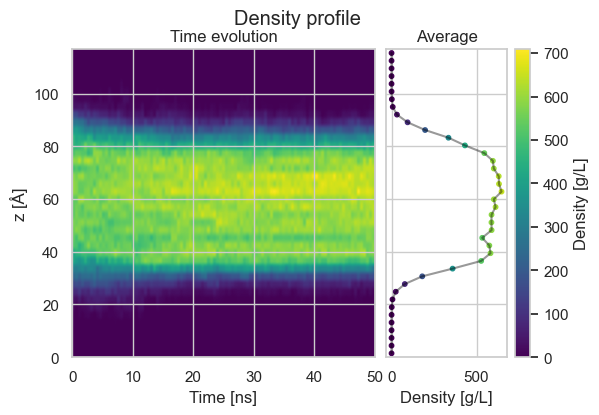

In [21]:
fig,ax = plt.subplots(1,2,figsize=(6,4), sharex=False, sharey=True, gridspec_kw={"width_ratios" : [2,1], "wspace" : 0.05})
im0 = ax[0].imshow(
    densities.T, 
    aspect='auto',
    origin='lower',
    extent=[times[0]/1000, times[-1]/1000, z_edges[0], z_edges[-1]],
    cmap='viridis'
)
plt.colorbar(im0,label='Density [g/L]',ax=ax[1])
ax[0].set_xlabel('Time [ns]')
ax[0].set_ylabel('z [Å]')
ax[0].set_title('Time evolution')

density_ave = densities[20:].mean(0)
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(densities.min(), densities.max())

ax[1].plot(density_ave,z_centers,c='black',alpha=0.4)
ax[1].scatter(density_ave,z_centers,color=cmap(norm(density_ave)),s=10)
ax[1].set_xlabel('Density [g/L]')
# ax[1].set_ylabel('z [Å]')
ax[1].set_title('Average')

plt.suptitle('Density profile')
plt.tight_layout()
h.save_png(fig,'../figures/density_profile.png')